In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
from lightgbm import LGBMClassifier

# Analysis libs
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X.shape

(58596, 50)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [8]:
# lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
clf = lgbm.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print('Train score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))
print('Test accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7614
[LightGBM] [Info] Number of data points in the train set: 41017, number of used features: 50
[LightGBM] [Info] Start training from score -0.693172
[LightGBM] [Info] Start training from score -1.789154
[LightGBM] [Info] Start training from score -1.766078
[LightGBM] [Info] Start training from score -1.820724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [9]:
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
cm

array([[8724,    4,   61,    1],
       [  59, 1749,  645,  484],
       [ 104,  531, 2034,  337],
       [  37,  865,  456, 1488]])

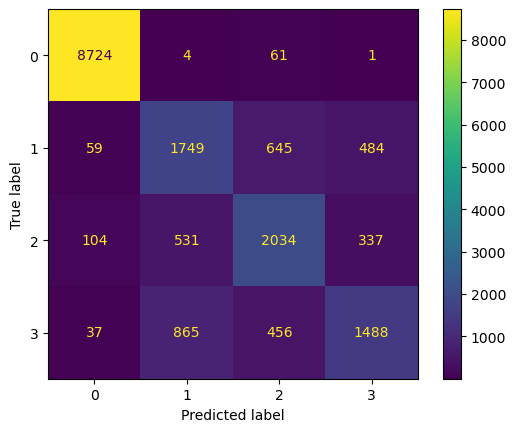

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [ ]:
print(classification_report(y_test, y_pred_test))